# Imports

## Importing Libraries

In [1]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset

## Importing Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Loading the dataset
data = pd.read_csv('/content/drive/MyDrive/Combined Data.csv')

In [5]:
data.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


# Data Preprocessing

## Dropping unecessary columns

In [6]:
data.dropna(inplace=True)
data.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

In [7]:
data.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [8]:
data=data.sample(n=5000,random_state=42).reset_index(drop=True)

In [9]:
data.head()

,statement,status
0,I'm lazy to complain about it ba ihh,Normal
1,i think the wifi on my iphone is broken it wil...,Normal
2,Good tracking apps? I've been trying to find a...,Bipolar
3,I have recently looked into reddit and found t...,Depression
4,that's your favorite thing to do?,Normal


## Cleaning the text

In [10]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords = set(stopwords.words("english"))

def clean_statement(text):

  #lowercasing
  text=text.lower()

  #removing symbols
  text=re.sub(r"[^a-zA-Z\s]",'',text)

  #splitting words
  text=text.split()

  #removing stopwords
  text=[word for word in text if word not in stopwords]

  #joining words
  text=' '.join(text)

  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
clean_statement("Hello there  @37&*!#%&) India won  !!") #check

'hello india'

In [12]:
data['statement']=data['statement'].apply(clean_statement) #apply
data.head()

,statement,status
0,im lazy complain ba ihh,Normal
1,think wifi iphone broken quot connect quot act...,Normal
2,good tracking apps ive trying find apps track ...,Bipolar
3,recently looked reddit found place actually qu...,Depression
4,thats favorite thing,Normal


## Balance Dataset

In [13]:
data['status'].value_counts()

,count
status,
Normal,1576
Depression,1437
Suicidal,1029
Anxiety,349
Bipolar,255
Stress,241
Personality disorder,113


In [14]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Oversampling
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X = data.drop(columns=['status'], axis=1)
y = data['status']

# Resampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Resampled Data in New Dataframe
data_resampled = pd.concat([X_resampled, y_resampled], axis=1)
print(data_resampled['status'].value_counts())


status
Normal                  1576
Bipolar                 1576
Depression              1576
Suicidal                1576
Stress                  1576
Personality disorder    1576
Anxiety                 1576
Name: count, dtype: int64


##  Encoding

In [15]:
label_encoder=LabelEncoder()
data_resampled['label']=label_encoder.fit_transform(data_resampled['status'])
data_resampled

,statement,status,label
0,im lazy complain ba ihh,Normal,3
1,think wifi iphone broken quot connect quot act...,Normal,3
2,good tracking apps ive trying find apps track ...,Bipolar,1
3,recently looked reddit found place actually qu...,Depression,2
4,thats favorite thing,Normal,3
...,...,...,...
11027,graduated highschool worry exams times graduat...,Suicidal,6
11028,wanting meet someone always lonely anyways liv...,Suicidal,6
11029,closer ever keep imagining parents feel sister...,Suicidal,6
11030,hey person asking advice last night painless s...,Suicidal,6


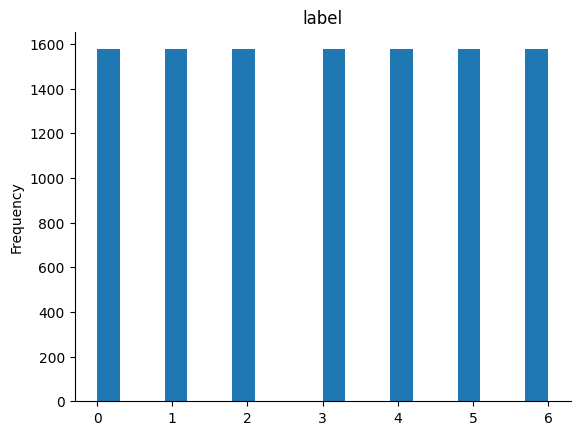

In [16]:
# @title Label distribution

from matplotlib import pyplot as plt
data_resampled['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Train test split

In [17]:
train_texts,test_texts,train_labels,test_labels=train_test_split(data_resampled['statement'],data_resampled['label'],test_size=0.2)

In [18]:
max([len(text) for text in data_resampled['statement']])

5893

# Logistic Regression

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [20]:
# Vectorizing the text data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(train_texts)
X_test_vec = vectorizer.transform(test_texts)

In [21]:
# Train lr
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_vec, train_labels)

LogisticRegression(max_iter=1000, random_state=42)

In [22]:
# Prediction
y_pred = lr_model.predict(X_test_vec)

In [23]:
# Evaluation
print("Accuracy:", accuracy_score(test_labels, y_pred))
print("Classification Report:\n", classification_report(test_labels, y_pred))

Accuracy: 0.9148164929768917
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       336
           1       0.99      1.00      1.00       308
           2       0.79      0.73      0.76       315
           3       0.88      0.93      0.90       280
           4       0.99      1.00      1.00       326
           5       0.95      0.99      0.97       312
           6       0.79      0.77      0.78       330

    accuracy                           0.91      2207
   macro avg       0.91      0.92      0.91      2207
weighted avg       0.91      0.91      0.91      2207



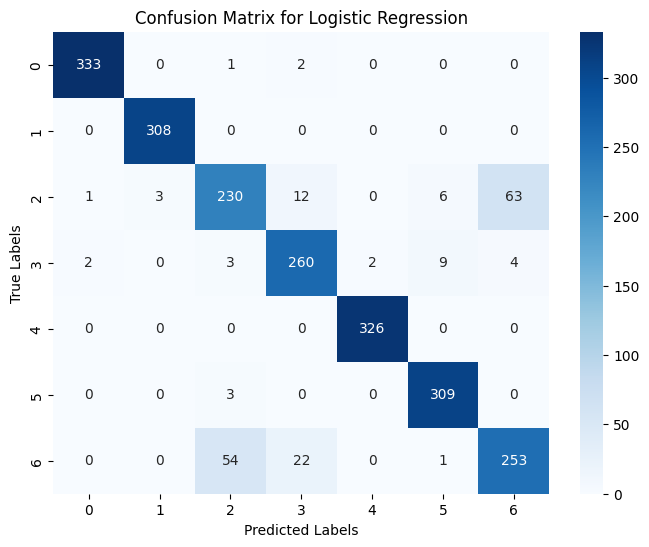

In [24]:
# Generate CM
conf_matrix = confusion_matrix(test_labels, y_pred)

# Plotting CM
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=lr_model.classes_,
            yticklabels=lr_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


# BERT

## Tokenization

In [26]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=256)
test_encodings = tokenizer(list(test_texts), padding=True, truncation=True, max_length=256)


In [27]:
# Convert to Dataset format
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels.tolist()
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels.tolist()
})


In [28]:
train_dataset[0]

{'input_ids': [101,
  2644,
  13318,
  2477,
  3331,
  2111,
  10397,
  14651,
  4385,
  18787,
  2471,
  3631,
  2559,
  2147,
  4786,
  2514,
  2066,
  2064,
  2102,
  10577,
  2131,
  2440,
  3052,
  2424,
  2209,
  2678,
  2399,
  2154,
  14175,
  2098,
  2417,
  23194,
  2851,
  3191,
  4391,
  2338,
  2746,
  2471,
  2847,
  19960,
  2015,
  2295,
  2667,
  11721,
  3676,
  2144,
  4312,
  2191,
  2130,
  4569,
  2905,
  5506,
  11888,
  3973,
  2969,
  8857,
  9471,
  2131,
  2067,
  4298,
  2893,
  2362,
  4596,
  3844,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

## Fine Tuning Bert

In [29]:
from sklearn.preprocessing import LabelEncoder
from transformers import BertForSequenceClassification

label_encd = LabelEncoder()
train_labels = label_encd.fit_transform(train_labels)  # Encode labels to integers
test_labels = label_encd.transform(test_labels)

# Number of unique labels
num_labels = len(label_encd.classes_)

# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Set training arguments with improvements
training_args = TrainingArguments(
    output_dir="./results",          # Output directory for results
    evaluation_strategy="epoch",     # Evaluate once per epoch
    save_strategy="epoch",          # Save model at the end of each epoch to match evaluation strategy
    learning_rate=2e-5,              # Learning rate
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    num_train_epochs=5,              # Increase number of epochs
    weight_decay=0.01,               # Strength of weight decay
    logging_dir="./logs",            # Directory for logging
    logging_steps=10,                # Log every 10 steps
    lr_scheduler_type="linear",      # Use linear learning rate scheduler with warmup
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    load_best_model_at_end=True,     # Load the best model at the end of training
    metric_for_best_model="eval_loss", # Monitor eval loss to determine the best model
    save_total_limit=3,              # Limit the number of checkpoints to save
    gradient_accumulation_steps=2    # Simulate larger batch size if GPU memory is limited
)
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Fine-tuning the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 22053101 (22053101-kiit-deemed-to-be-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,1.219200,1.201525
2,0.388200,0.393198
3,0.169600,0.274293
4,0.147000,0.263038
5,0.087200,0.262354


TrainOutput(global_step=1380, training_loss=0.5946125342794086, metrics={'train_runtime': 2000.8215, 'train_samples_per_second': 22.053, 'train_steps_per_second': 0.69, 'total_flos': 5805148257600000.0, 'train_loss': 0.5946125342794086, 'epoch': 5.0})

## Model Evaluation

                      precision    recall  f1-score   support

             Anxiety       0.98      0.97      0.97       336
             Bipolar       0.97      1.00      0.98       308
          Depression       0.74      0.72      0.73       315
              Normal       0.95      0.90      0.93       280
Personality disorder       0.99      1.00      1.00       326
              Stress       0.95      0.99      0.97       312
            Suicidal       0.79      0.79      0.79       330

            accuracy                           0.91      2207
           macro avg       0.91      0.91      0.91      2207
        weighted avg       0.91      0.91      0.91      2207



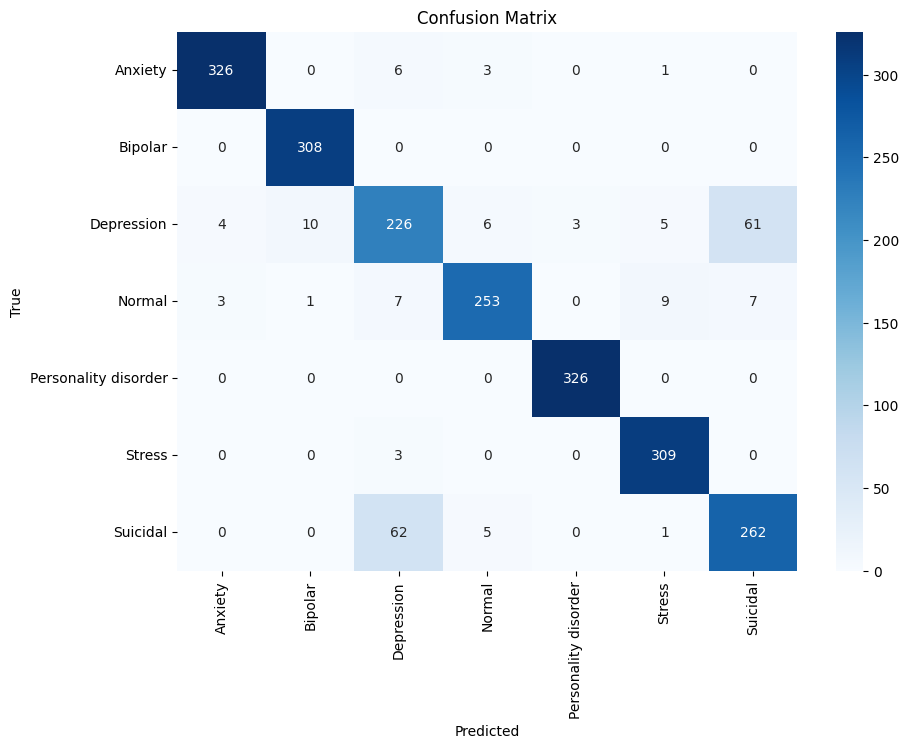

In [32]:
# Predictions
predictions, labels, _ = trainer.predict(test_dataset)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Classification Report
print(classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Save and Load Model and Tokenizer

In [33]:
# Save the trained model and tokenizer
trainer.save_model("saved_mental_status_bert")  # Save the model to the specified directory
tokenizer.save_pretrained("saved_mental_status_bert")  # Save the tokenizer


import pickle

pickle.dump(label_encoder, open('label_encoder.pkl', 'wb'))

In [34]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model and tokenizer from the saved paths
model = AutoModelForSequenceClassification.from_pretrained("saved_mental_status_bert")
tokenizer = AutoTokenizer.from_pretrained("saved_mental_status_bert")

label_encoder = pickle.load(open('label_encoder.pkl', 'rb'))

## Detection System

In [35]:
# Detection System
def detect(text):
    cleaned_text = clean_statement(text)
    inputs = tokenizer(cleaned_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]

sample_texts = [
    "I keep overthinking everything, and it’s exhausting.",
    "I went to the store to buy groceries today.",
    "It's a pretty average day at work, nothing special.",
    "I just got promoted at work, and I’m feeling amazing!",
    "I feel so lonely, and nothing seems to make me feel better.",
    "I’ve been trying to keep it together, but everything feels so heavy.",
    "I can’t stop thinking about how much I miss them.",
    "My heart races whenever I have to speak in front of people.",
    "The constant fear of failing is making me restless.",
    "I feel like I’m drowning, and there’s no way out.",
    "Why does everything always go wrong for me?!",
    "I just booked my dream vacation, and I can’t wait to go!",
    "I got accepted into my top choice university, this is unreal!",
    "I’m terrified of what might happen if things go wrong.",
    "I’m so thankful for the people who support me.",
    "I feel lost and don’t know what to do next.",
    "Everything is so unclear, and I can’t seem to focus.",
    "I’m trying to understand, but nothing makes sense.",
    "I appreciate everything you’ve done for me.",
    "Life feels brighter because of all the kindness I’ve received.",
    "The darkness feels suffocating, and I can’t escape it.",
    "I can’t shake this feeling that something bad is about to happen.",
    "This concert is going to be amazing, I’m counting down the days!",
    "I can’t stand being treated like this anymore.",
    "It’s so unfair how people take advantage of my kindness.",
    "Today was so much fun, spent the whole day with friends!",
    "I can’t stop smiling. Life feels so good right now.",
    "I have a meeting scheduled at 10 AM tomorrow."
]

for text in sample_texts:
    predicted_class = detect(text)
    print(f"Sentence: {text}\nPredicted class: {predicted_class}\n")


Sentence: I keep overthinking everything, and it’s exhausting.
Predicted class: Depression

Sentence: I went to the store to buy groceries today.
Predicted class: Normal

Sentence: It's a pretty average day at work, nothing special.
Predicted class: Normal

Sentence: I just got promoted at work, and I’m feeling amazing!
Predicted class: Normal

Sentence: I feel so lonely, and nothing seems to make me feel better.
Predicted class: Suicidal

Sentence: I’ve been trying to keep it together, but everything feels so heavy.
Predicted class: Normal

Sentence: I can’t stop thinking about how much I miss them.
Predicted class: Normal

Sentence: My heart races whenever I have to speak in front of people.
Predicted class: Normal

Sentence: The constant fear of failing is making me restless.
Predicted class: Anxiety

Sentence: I feel like I’m drowning, and there’s no way out.
Predicted class: Normal

Sentence: Why does everything always go wrong for me?!
Predicted class: Depression

Sentence: I jus

## Downlaod Model To Your PC Directly

In [36]:
import shutil
from google.colab import files

# Step 1: Save the trained model and tokenizer
model_save_path = "saved_mental_status_bert"  # Path to save the trained model
tokenizer_save_path = "saved_mental_status_bert"  # Path to save the tokenizer

# Save the model and tokenizer
trainer.save_model(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

# Step 2: Create a zip file containing the saved model and tokenizer using shutil
zip_file_path = "saved_mental_status_bert"  # Path for the zip file without extension

# Create a zip archive of the directories
shutil.make_archive(zip_file_path, 'zip', root_dir='saved_mental_status_bert', base_dir='')

# Step 3: Provide a download link to the zip file
files.download(f"{zip_file_path}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>